# Building on the previous notebook we now develop barycentric integrators for both 2D and 3D.

In this notebook the 3D barycentric computations.


In [19]:

#import polyscope as ps


# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [20]:
## Imports and physical parameters
# std library

# plotting

# ddg imports
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from ddgclib._case1 import *
from ddgclib._complex import *
from ddgclib._capillary_rise import * #plot_surface#, curvature
from ddgclib._plotting import *

# Parameters for a water droplet in air at standard laboratory conditions
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

# Parameters from EoS:
T_0 = 273.15 + 25  # K, initial tmeperature
P_0 = 101.325  # kPa, ambient pressure
#gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
#rho_0 = eos(P=P_0, T=T_0)  # kg/m3, densi
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

# Capillary rise parameters
r = 2.0  # m, radius of the tube
theta_p = 0 * np.pi/180.0  # Three phase contact angle
theta_p = 20 * np.pi/180.0  # Three phase contact angle
theta_p = 50 * np.pi/180.0  # Three phase contact angle

R = r / np.cos(theta_p)  # = R at theta = 0
# Exact values:
K_f = (1 / R) ** 2
H_f = 1 / R + 1 / R  # 2 / R

def distance_matrix(A, B, squared=False):
    """
    Compute all pairwise distances between vectors in A and B.

    Parameters
    ----------
    A : np.array
        shape should be (M, K)
    B : np.array
        shape should be (N, K)

    Returns
    -------
    D : np.array
        A matrix D of shape (M, N).  Each entry in D i,j represnets the
        distance between row i in A and row j in B.

    See also
    --------
    A more generalized version of the distance matrix is available from
    scipy (https://www.scipy.org) using scipy.spatial.distance_matrix,
    which also gives a choice for p-norm.
    """
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*A.dot(B.T)

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared

def cotan(theta):
    return 1 / np.tan(theta)


In [21]:
def compute_vd_OLD(HC, cdist =1e-10):
    """
    Computes the dual vertices of a primal vertex cache HC.V on
    each dim - 1 simplex.
    
    Currently only dim = 2 is supported
    
    cdist: float, tolerance for where a unique dual vertex can exist
    
    """
    # Construct dual cache
    HC.Vd = VertexCacheField() 
    
    # Construct dual neighbour sets
    for v in HC.V:
        v.vd = set()
            
    #hcv = copy.copy(HC.V)        
    for v1 in HC.V:
        for v2 in v1.nn:
            # Find all v2.nn also connected to v1:
            v1nn_u_v2nn = v1.nn.intersection(v2.nn)
            for v3 in v1nn_u_v2nn:
                # TODO: Re-implement cache:
                verts = np.zeros([3, 2])
                verts[0] = v1.x_a
                verts[1] = v2.x_a
                verts[2] = v3.x_a
                # Compute the circumcentre:
                cd = circumcenter(verts)
                # Note instead of below, could round off cd in general to say nearest 1e-12
                # Check for uniqueness first (new, expensive, could 
                # be improved by checking duals of neighbours only?):
                for vd_i in HC.Vd:
                    dist = np.linalg.norm(vd_i.x_a - cd)
                    if dist < cdist:
                        cd = vd_i.x_a
                        
                vd = HC.Vd[tuple(cd)]
                # Connect to all primal vertices
                for v in [v1, v2, v3]:
                    v.vd.add(vd)
                    vd.nn.add(v)
                    
    return HC  # self


# Find the Delaunay dual
def triang_dual(points, plot_delaunay=False):
    """
    Compute the Delaunay triangulation plus the dual points. Put into hyperct complex object.
    
    """
    tri = Delaunay(points)
    if plot_delaunay:  # Plot Delaunay complex
        import matplotlib.pyplot as plt
        plt.triplot(points[:,0], points[:,1], tri.simplices)
        plt.plot(points[:,0], points[:,1], 'o')
        plt.show()

    # Put Delaunay back into hyperct Complex object:
    HC = Complex(2)
    for s in tri.simplices:
        for v1i in s:
            for v2i in s:
                if v1i is v2i:
                    continue
                else:
                    v1 = tuple(points[v1i])
                    v2 = tuple(points[v2i])
                    HC.V[v1].connect(HC.V[v2])

    return HC, tri


# Plot duals
def plot_dual_mesh_2D(HC, tri):
    """
    Plot the dual mesh and show edge connectivity. Blue is the primary mesh. Orange is the dual mesh.
    """
    import matplotlib.pyplot as plt
    
    # Find the dual points
    dual_points = []
    for vd in HC.Vd:
        dual_points.append(vd.x_a)
    dual_points = np.array(dual_points)
    # Primal points 
    points = []
    for v in HC.V:
        points.append(v.x_a)
        
    points = np.array(points)
    
    for v in HC.V:
        # "Connect duals":
        for v2 in v.nn:
            v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
            if len(v1vdv2vd) == 1:
                continue
            v1vdv2vd = list(v1vdv2vd)
            x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
            y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
            plt.plot(x, y, color='orange')

        for vd in v.vd:
            x = [v.x[0], vd.x[0]]
            y = [v.x[1], vd.x[1]]
            plt.plot(x, y, '--', color='tab:green')
    plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
    plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
    plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

    plt.show()

# Area computations
def d_area(vp1):
    """
    Compute the dual area of a vertex object vp1, which is the sum of the areas
    of the local dual triangles formed between vp1, its neighbouring vertices, 
    and their shared dual vertices.

    Parameters:
    -----------
    vp1 : object
        A vertex object containing the following attributes:
        - vp1.nn: a list of neighboring vertex objects
        - vp1.vd: a set of dual vertex objects
        - vp1.x_a: a numpy array representing the position of vp1

    Returns:
    --------
    darea : float
        The total dual area of the vertex object vp1
    """

    darea = 0  # Initialize total dual area to zero
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        h = np.linalg.norm(mp - vp1.x_a)
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)
            # Add the area of the dual triangle to the total dual area
            darea += 0.5 * b * h

    return darea

# DDG
def dP(vp1):
    """
    Compute the integrated pressure differential for vertex v     
    """
    dP_i = 0  # Total integrated Laplacian for each vertex
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
      #  l_ij = np.linalg.norm(vp2.x_a - vp1.x_a)  # Not used here?
        e_dual = 0  # Initialize total edge dual length to zero
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        #h = np.linalg.norm(mp - vp1.x_a)
        #print(f'vdnn = {vdnn})
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)  # dihedral weight
            # Add the area of the dual triangle to the total dual area
            e_dual += b
            if e_dual <= 1e-12:  # TODO: Set tolerance
                e_dual = 0
               
        #w_ij = l_ij/e_dual  # Weight
        #if (w_ij is np.inf) or (e_dual == 0):
        
            continue
        # Compute the area flux for the pressure differential:
        Area = e_dual* 1  # m2, Chosen height was 1 for our 2D test case
        # Compute the dual
        dP_ij = Area * (vp2.P - vp1.P)
        dP_i += dP_ij
        
    return dP_i

def du(vp1):
    """
    Compute the Laplacian of the velocity field for vertex v
    
    TODO: Compare this with the     
    """
    du_i = 0  # Total integrated Laplacian for each vertex
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
        l_ij = np.linalg.norm(vp2.x_a - vp1.x_a)
        e_dual = 0  # Initialize total edge dual length to zero
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        #h = np.linalg.norm(mp - vp1.x_a)
        #print(f'vdnn = {vdnn})
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)  # dihedral weight
            # Add the area of the dual triangle to the total dual area
            e_dual += b
            if e_dual <= 1e-12:  # TODO: Set tolerance
                e_dual = 0
               
        w_ij = l_ij/e_dual  # Weight
       # print('.')
       # print(f'l_ij = {l_ij}')
       # print(f'e_dual, len(vdnn)  = {e_dual, len(vdnn)}')
       # print(f'w_ij = { w_ij}')
       # print(f'w_ij is np.inf = {w_ij is np.inf}')
       # print(f'w_ij == np.inf = {w_ij == np.inf}')
        if (w_ij is np.inf) or (e_dual == 0):
            continue
        # Compute the dual
        du_ij = w_ij * (vp2.u - vp1.u)
        du_i += du_ij
        
    return du_i

def dudt(v):
    # Equal to the acceleration at a vertex (RHS of equation)
    dudt = -dP(v) + mu * du(v)
    dudt = dudt/v.m  # normalize by mass
    return dudt

## ... to Barycentric

In [22]:
def compute_vd(HC, cdist =1e-10):
    """
    Computes the dual vertices of a primal vertex cache HC.V on
    each dim - 1 simplex.
    
    Currently only dim = 2 is supported
    
    cdist: float, tolerance for where a unique dual vertex can exist
    
    """
    # Construct dual cache
    HC.Vd = VertexCacheField() 
    
    # Construct dual neighbour sets
    for v in HC.V:
        v.vd = set()
            
    #hcv = copy.copy(HC.V)        
    for v1 in HC.V:
        for v2 in v1.nn:
            # Find all v2.nn also connected to v1:
            v1nn_u_v2nn = v1.nn.intersection(v2.nn)
            for v3 in v1nn_u_v2nn:
                # TODO: Re-implement cache:
                verts = np.zeros([3, HC.dim])
                verts[0] = v1.x_a
                verts[1] = v2.x_a
                verts[2] = v3.x_a
                
                # Compute the circumcentre:
                #cd = circumcenter(verts)
                # Compute the barycentre:
                cd = np.mean(verts, axis=0)
                # Note instead of below, could round off cd in general to say nearest 1e-12
                # Check for uniqueness first (new, expensive, could 
                # be improved by checking duals of neighbours only?):
                for vd_i in HC.Vd:
                    dist = np.linalg.norm(vd_i.x_a - cd)
                    if dist < cdist:
                        cd = vd_i.x_a
                        
                vd = HC.Vd[tuple(cd)]
                # Connect to all primal vertices
                for v in [v1, v2, v3]:
                    v.vd.add(vd)
                    vd.nn.add(v)
                    
    return HC  # self

In [23]:
HC = compute_vd(HC, cdist =1e-10)

In [24]:
for v in HC.V:
    print(v.vd)

{<ddgclib._vertex.VertexScalarField object at 0x7f405450fe90>, <ddgclib._vertex.VertexScalarField object at 0x7f405450c710>, <ddgclib._vertex.VertexScalarField object at 0x7f405450d3d0>}
{<ddgclib._vertex.VertexScalarField object at 0x7f405450d3d0>, <ddgclib._vertex.VertexScalarField object at 0x7f405450e210>, <ddgclib._vertex.VertexScalarField object at 0x7f405450f5d0>, <ddgclib._vertex.VertexScalarField object at 0x7f405450c350>, <ddgclib._vertex.VertexScalarField object at 0x7f405450e4d0>, <ddgclib._vertex.VertexScalarField object at 0x7f405450fe90>}
{<ddgclib._vertex.VertexScalarField object at 0x7f405450e210>, <ddgclib._vertex.VertexScalarField object at 0x7f405450fe90>}
{<ddgclib._vertex.VertexScalarField object at 0x7f405450e9d0>, <ddgclib._vertex.VertexScalarField object at 0x7f405450e210>, <ddgclib._vertex.VertexScalarField object at 0x7f405450e4d0>}
{<ddgclib._vertex.VertexScalarField object at 0x7f405450e010>, <ddgclib._vertex.VertexScalarField object at 0x7f405450c710>, <dd

# Plot functions

In [25]:
points = []
for v in HC.V:
    points.append(v.x)

In [26]:
points

[(2.0, 1.0),
 (1.5, 0.5),
 (2.0, 0.0),
 (1.0, 0.0),
 (1.5, 1.5),
 (2.0, 2.0),
 (1.0, 2.0),
 (0.5, 0.5),
 (0.0, 0.0),
 (0.0, 1.0),
 (0.5, 1.5),
 (0.0, 2.0),
 (1.0, 1.0)]

In [27]:
HC, tri = triang_dual(points)
HC.dim = 3
HC = compute_vd(HC, cdist =1e-10)

plot_dual_mesh_2D(HC, tri)

ValueError: could not broadcast input array from shape (2,) into shape (3,)

In [28]:
for v in HC.V:
    print(v.x)

(1.5, 0.5)
(2.0, 0.0)
(2.0, 1.0)
(1.0, 0.0)
(2.0, 2.0)
(1.5, 1.5)
(1.0, 2.0)
(0.5, 0.5)
(0.0, 0.0)
(0.0, 1.0)
(0.5, 1.5)
(0.0, 2.0)
(1.0, 1.0)


In [29]:
for v in HC.Vd:
    print(v.x)

In [30]:
HC, tri = triang_dual(points)
HC.dim = 3
HC = compute_vd(HC, cdist =1e-10)

ValueError: could not broadcast input array from shape (2,) into shape (3,)

In [31]:
# Test case traingulation
def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points)
    tri = Delaunay(points)
    return points

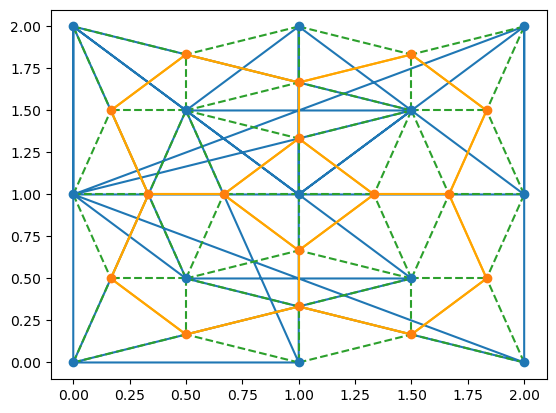

In [32]:
domain = [(0, 2),]*2
points = incom_Poi(domain, refinements=1)
HC, tri = triang_dual(points)
HC = compute_vd(HC, cdist =1e-10)

plot_dual_mesh_2D(HC, tri)

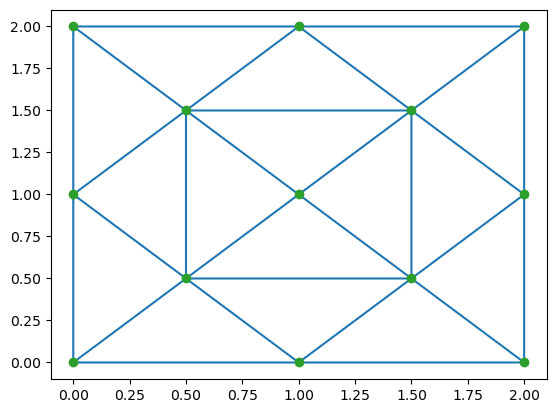

In [33]:
import numpy as np
#points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
from scipy.spatial import Delaunay
tri = Delaunay(points)

import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [34]:
dual_points = []
for vd in HC.Vd:
    #print('-')
    #print(vd.x_a)
    dual_points.append(vd.x_a)
    #for vdn in vd.v
dual_points = np.array(dual_points)

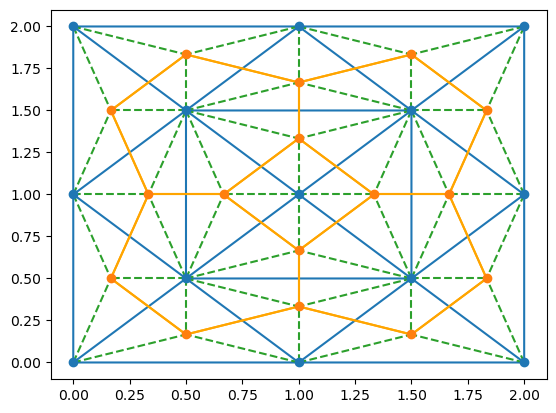

In [35]:
import matplotlib.pyplot as plt
for v in HC.V:
    # "Connect duals":
    for v2 in v.nn:
        v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
        if len(v1vdv2vd) == 1:
            continue
        v1vdv2vd = list(v1vdv2vd)
        x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
        y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
        plt.plot(x, y, color='orange')
        
    for vd in v.vd:
        x = [v.x[0], vd.x[0]]
        y = [v.x[1], vd.x[1]]
        plt.plot(x, y, '--', color='tab:green')
plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

plt.show()

# Insight:

This is clearly very different from the barycentric duals:

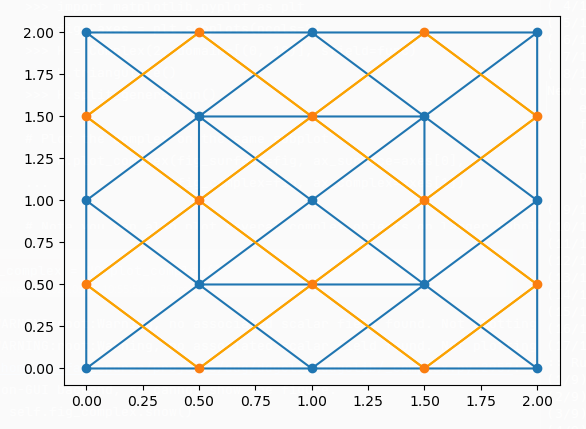

Should be fine??? Haha.

In [36]:
points = [(0.0, 0.0, -0.7279404685324046831),
 (0.0, 2.0000000000000000408, 0.0),
 (1.732050807568877481, -0.9999999999999995939, 0.0),
 (-1.7320508075688767606, -1.0000000000000008948, 0.0)]

points = np.array(points)
points = points[:, :2]
points 

array([[ 0.        ,  0.        ],
       [ 0.        ,  2.        ],
       [ 1.73205081, -1.        ],
       [-1.73205081, -1.        ]])

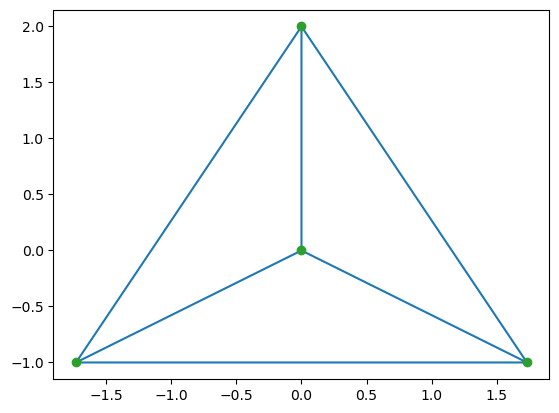

In [37]:
import numpy as np
#points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
from scipy.spatial import Delaunay
tri = Delaunay(points)

import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [38]:
dual_points = []
for vd in HC.Vd:
    #print('-')
    #print(vd.x_a)
    dual_points.append(vd.x_a)
    #for vdn in vd.v
dual_points = np.array(dual_points)

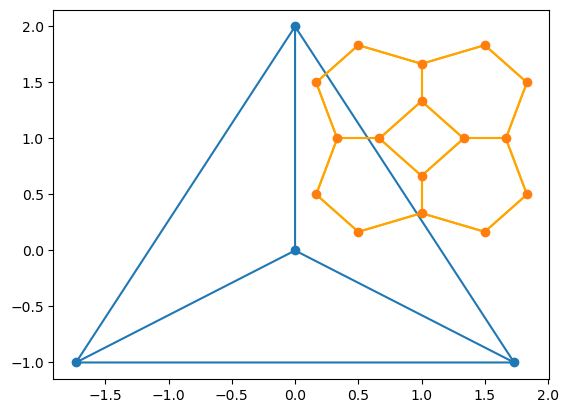

In [39]:
import matplotlib.pyplot as plt
for v in HC.V:
    # "Connect duals":
    for v2 in v.nn:
        v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
        if len(v1vdv2vd) == 1:
            continue
        v1vdv2vd = list(v1vdv2vd)
        x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
        y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
        plt.plot(x, y, color='orange')
        
    for vd in v.vd:
        x = [v.x[0], vd.x[0]]
        y = [v.x[1], vd.x[1]]
        #plt.plot(x, y, '--', color='tab:green')
plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

plt.show()

In [40]:
HC, tri = triang_dual(points, plot_delaunay=False)

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2957: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2962: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_surface.show()


(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 <Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='$x_1$', ylabel='$x_2$', zlabel='$f$'>)

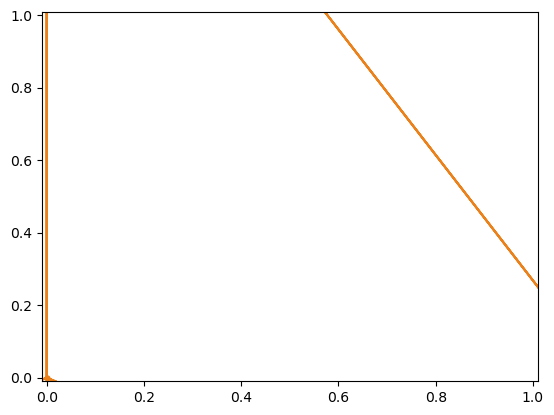

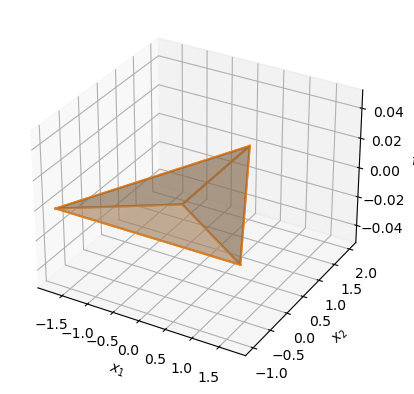

In [41]:
HC.plot_complex()

In [42]:
HC = compute_vd(HC, cdist =1e-10)
dual_points = []
for vd in HC.Vd:
    #print('-')
    #print(vd.x_a)
    dual_points.append(vd.x_a)
    #for vdn in vd.v
dual_points = np.array(dual_points)

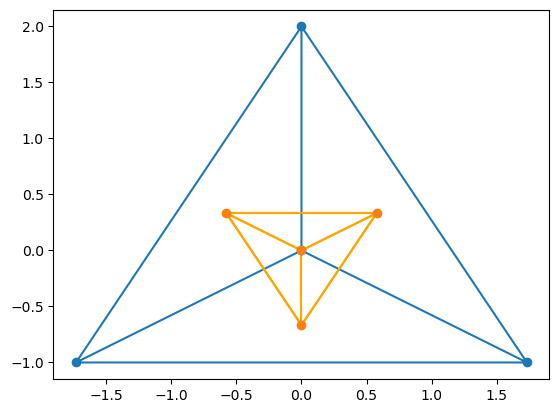

(None,
 array([[ 2.22044605e-16, -1.48029737e-16],
        [ 2.22044605e-16, -6.66666667e-01],
        [ 5.77350269e-01,  3.33333333e-01],
        [-5.77350269e-01,  3.33333333e-01]], dtype=float128))

In [43]:
import matplotlib.pyplot as plt
for v in HC.V:
    # "Connect duals":
    for v2 in v.nn:
        v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
        if len(v1vdv2vd) == 1:
            continue
        v1vdv2vd = list(v1vdv2vd)
        x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
        y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
        plt.plot(x, y, color='orange')
        
    for vd in v.vd:
        x = [v.x[0], vd.x[0]]
        y = [v.x[1], vd.x[1]]
        #plt.plot(x, y, '--', color='tab:green')
plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

plt.show(), dual_points

# 3 D


In [123]:
def compute_vd(HC, cdist =1e-10):
    """
    Computes the dual vertices of a primal vertex cache HC.V on
    each dim - 1 simplex.
    
    Currently only dim = 2, 3 is supported
    
    cdist: float, tolerance for where a unique dual vertex can exist
    
    """
    # Construct dual cache
    HC.Vd = VertexCacheField() 
    
    # Construct dual neighbour sets
    for v in HC.V:
        v.vd = set()
        
        
            
    #hcv = copy.copy(HC.V)        
    if HC.dim == 2:
        for v1 in HC.V:
            for v2 in v1.nn:
                
                # Find all v2.nn also connected to v1:
                v1nn_u_v2nn = v1.nn.intersection(v2.nn)
                for v3 in v1nn_u_v2nn:
                    if (v3 is v1):
                        continue
                    # TODO: Re-implement cache:
                    verts = np.zeros([3, HC.dim])
                    verts[0] = v1.x_a
                    verts[1] = v2.x_a
                    verts[2] = v3.x_a

                    # Compute the circumcentre:
                    #cd = circumcenter(verts)
                    # Compute the barycentre:
                    cd = np.mean(verts, axis=0)
                    # Note instead of below, could round off cd in general to say nearest 1e-12
                    # Check for uniqueness first (new, expensive, could 
                    # be improved by checking duals of neighbours only?):
                    for vd_i in HC.Vd:
                        dist = np.linalg.norm(vd_i.x_a - cd)
                        if dist < cdist:
                            cd = vd_i.x_a

                    vd = HC.Vd[tuple(cd)]
                    # Connect to all primal vertices
                    for v in [v1, v2, v3]:
                        v.vd.add(vd)
                        vd.nn.add(v)
    elif HC.dim ==3:
        for v1 in HC.V:
            for v2 in v1.nn:
                # Find all v2.nn also connected to v1:
                v1nn_u_v2nn = v1.nn.intersection(v2.nn)
                for v3 in v1nn_u_v2nn:
                    if (v3 is v1):
                        continue
                    v1nn_u_v2nn_u_v3nn = v1nn_u_v2nn.intersection(v3.nn)
                    #for v4 in v1nn_u_v2nn_u_v3nn:
                    for v4 in v1nn_u_v2nn_u_v3nn:
                        if (v4 is v1) or (v4 is v2):
                            continue
                        # TODO: Re-implement cache:
                        verts = np.zeros([HC.dim+1, HC.dim])
                        #print(verts)
                        verts[0] = v1.x_a
                        verts[1] = v2.x_a
                        verts[2] = v3.x_a
                        verts[3] = v4.x_a
                        print(verts)

                        # Compute the circumcentre:
                        #cd = circumcenter(verts)
                        # Compute the barycentre:
                        cd = np.mean(verts, axis=0)
                        # Note instead of below, could round off cd in general to say nearest 1e-12
                        # Check for uniqueness first (new, expensive, could 
                        # be improved by checking duals of neighbours only?):
                        for vd_i in HC.Vd:
                            dist = np.linalg.norm(vd_i.x_a - cd)
                            if dist < cdist:
                                cd = vd_i.x_a

                        vd = HC.Vd[tuple(cd)]
                        # Connect to all primal vertices
                        for v in [v1, v2, v3]:
                            v.vd.add(vd)
                            vd.nn.add(v)
    return HC  # self

In [124]:
domain = [(0, 2),]*3
symmetry = [0, 0, 0]
HC = Complex(3, domain=domain, symmetry=symmetry)
HC.triangulate()
compute_vd(HC, cdist =1e-10)
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
dual_points

vl = (0, 0, 0)
vu = (2, 0, 0)
vp = (0, 0, 0)
vp = (2, 2, 0)
-
ab_v = [2, 2, 0]
vl = (2, 0, 0)
vu = (2, 2, 0)
vp = (0, 0, 0)
vp = (2, 2, 0)
-
ab_v = [2, 2, 2]
vp = (0, 0, 0)
vp = (2, 2, 0)
-
ab_v = [2, 2, 2]
vp = (2, 0, 0)
vp = (2, 2, 2)
-
ab_v = [2, 2, 2]
[[0. 0. 0.]
 [2. 0. 0.]
 [2. 2. 0.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [2. 0. 0.]
 [1. 1. 1.]
 [2. 2. 0.]]
[[0. 0. 0.]
 [2. 2. 0.]
 [1. 1. 1.]
 [2. 0. 0.]]
[[0. 0. 0.]
 [2. 2. 0.]
 [2. 0. 0.]
 [1. 1. 1.]]
[[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 0.]
 [2. 0. 0.]]
[[0. 0. 0.]
 [1. 1. 1.]
 [2. 0. 0.]
 [2. 2. 0.]]
[[2. 2. 2.]
 [2. 2. 0.]
 [1. 1. 1.]
 [2. 0. 0.]]
[[2. 2. 2.]
 [2. 2. 0.]
 [2. 0. 0.]
 [1. 1. 1.]]
[[2. 2. 2.]
 [1. 1. 1.]
 [2. 2. 0.]
 [2. 0. 0.]]
[[2. 2. 2.]
 [1. 1. 1.]
 [2. 0. 0.]
 [2. 2. 0.]]
[[2. 2. 2.]
 [2. 0. 0.]
 [2. 2. 0.]
 [1. 1. 1.]]
[[2. 2. 2.]
 [2. 0. 0.]
 [1. 1. 1.]
 [2. 2. 0.]]
[[2. 0. 0.]
 [0. 0. 0.]
 [2. 2. 0.]
 [1. 1. 1.]]
[[2. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 0.]]
[[2. 0. 0.]
 [2. 2. 0.]
 [0. 0. 0.]
 [1. 1. 1.]]
[[2. 0. 0

array([[1.25, 0.75, 0.25],
       [1.75, 1.25, 0.75]])

In [125]:
#compute_vd(HC, cdist =1e-10)

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2957: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


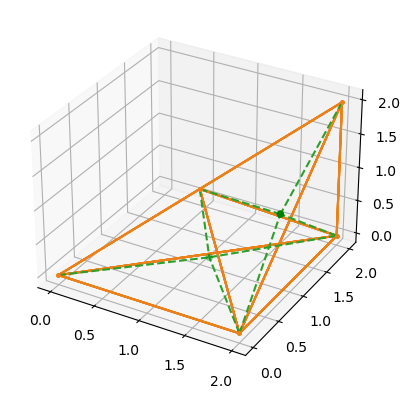

In [126]:
#hcaxes.scatter(dual_points)
hcfig, hcaxes, _, _ = HC.plot_complex()
hcaxes.scatter3D(dual_points[:, 0], dual_points[:, 1], dual_points[:, 2], color = "green")
for v in HC.V:
    for vd in v.vd:
        x = [v.x[0], vd.x[0]]
        y = [v.x[1], vd.x[1]]
        z = [v.x[2], vd.x[2]]
        hcaxes.plot(x, y, zs=z, linestyle='--',  color='tab:green')
    #ax.plot([VecStart_x[i], VecEnd_x[i]], [VecStart_y[i],VecEnd_y[i]],zs=[VecStart_z[i],VecEnd_z[i]])

plt.show()

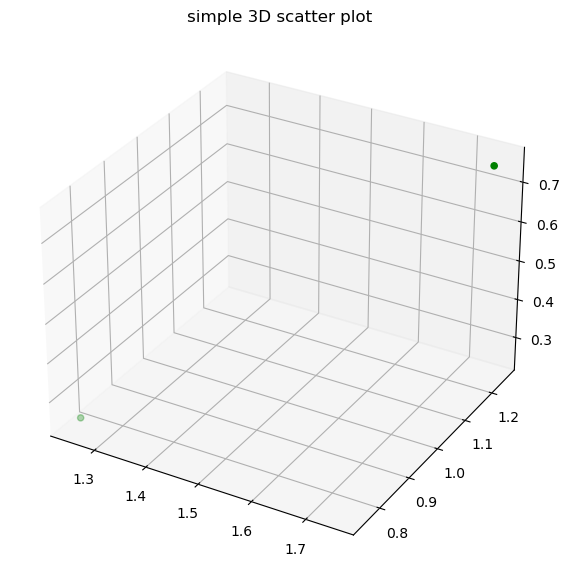

In [121]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

x, y, z = dual_points[:, 0], dual_points[:, 1], dual_points[:, 2]
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
for v in HC.V:
    # "Connect duals":
    for v2 in v.nn:
        v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
        if len(v1vdv2vd) == 1:
            continue
        v1vdv2vd = list(v1vdv2vd)
        x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
        y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
        plt.plot(x, y, color='orange')
        
    for vd in v.vd:
        x = [v.x[0], vd.x[0]]
        y = [v.x[1], vd.x[1]]
        plt.plot(x, y, '--', color='tab:green')
plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

plt.show()